<a href="https://colab.research.google.com/github/SoumeshNayak/DeepLearning-Image-Classification/blob/main/FUNCTIONAL_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Model

**Example 1**

In [14]:
model=Model(inputs=x,outputs=[output1,output2])

In [2]:
from keras.layers import *

In [7]:
x=Input(shape=(3,))

In [8]:
hidden1=Dense(128,activation='relu')(x)  #means hidden later connected to x

In [9]:
hidden2=Dense(64,activation='relu')(hidden1)

output1=Dense(1,activation='linear')(hidden2)
output2=Dense(1,activation='sigmoid')(hidden2)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          512         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            65          ['dense_1[0][0]']                
                                                                                              

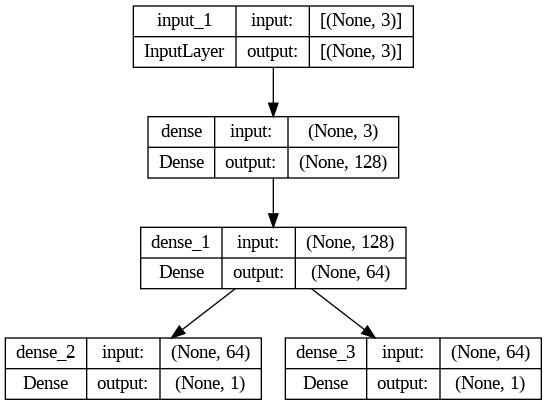

In [13]:
#to visualize the model
from keras.utils import plot_model
plot_model(model,show_shapes=True)

**Example 2**

In [15]:
inputA=Input(shape=(32,))
inputB=Input(shape=(128,))


In [16]:
x=Dense(8,activation='relu')(inputA)
x1=Dense(4,activation="relu")(x)

In [17]:
y=Dense(64,activation="relu")(inputB)
y1=Dense(32,activation='relu')(y)
y2=Dense(4,activation='relu')(y1)

In [19]:
combine=concatenate([x1,y1])

In [20]:
z=Dense(2,activation='relu')(combine)
z1=Dense(1,activation='linear')(z)

In [22]:
model=Model(inputs=[inputA,inputB],outputs=z1)

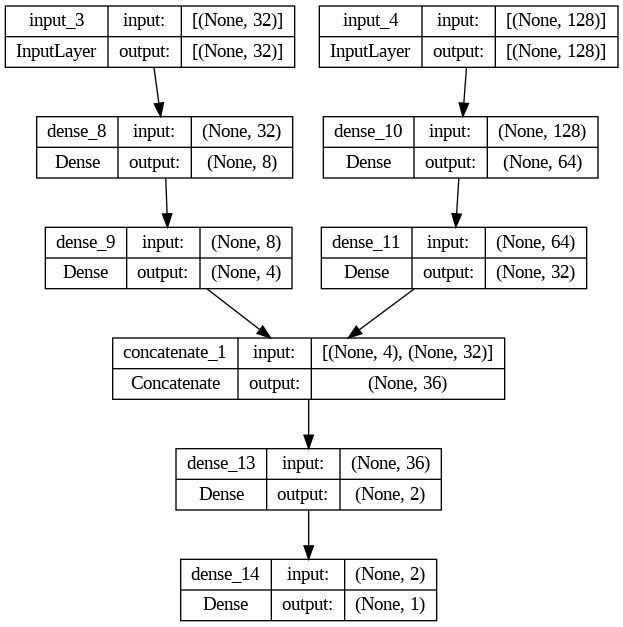

In [24]:
plot_model(model,show_shapes=True)

In [1]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 94% 310M/331M [00:02<00:00, 171MB/s]
100% 331M/331M [00:02<00:00, 130MB/s]


In [3]:
import zipfile
zip=zipfile.ZipFile('/content/utkface-new.zip','r')
zip.extractall('/content')
zip.close()

In [4]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [5]:
folder_path='/content/utkface_aligned_cropped/UTKFace'

In [6]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [7]:
len(age)

23708

In [8]:
df=pd.DataFrame({'age':age,'gender':gender,'image':img_path})

In [9]:
df.head()

,age,gender,image
0,35,1,35_1_2_20170112191512046.jpg.chip.jpg
1,26,1,26_1_0_20170117003226902.jpg.chip.jpg
2,58,0,58_0_0_20170105173528685.jpg.chip.jpg
3,36,0,36_0_3_20170119202053413.jpg.chip.jpg
4,24,1,24_1_2_20170116175450531.jpg.chip.jpg


In [10]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]

In [11]:
train_df.shape

(20000, 3)

In [12]:
test_df.shape

(3708, 3)

In [15]:
# Use generator 
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
#we are generating the images and storing it in folder with input as image and output as ['age','gender']
train_generator=train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='image',
    y_col=['age','gender'],
    target_size=(200,200),
    class_mode='multi_output'
)
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='image',
    y_col=['age','gender'],
    target_size=(200,200),
    class_mode='multi_output'
)


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [18]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [19]:
vggnet=VGG16(include_top=False,input_shape=(200,200,3))

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
vggnet.trainable=False

output=vggnet.layers[-1].output # Here we are fetching output of last layer of vgg16
flatten=Flatten()(output)

dense1=Dense(512,activation='relu')(flatten)
dense2=Dense(512,activation='relu')(flatten)

dense3=Dense(512,activation='relu')(dense1)
dense4=Dense(512,activation='relu')(dense2)

output1=Dense(1,activation='linear',name='age')(dense3)
output2=Dense(1,activation='sigmoid',name='gender')(dense4)

In [22]:
model=Model(inputs=vggnet.input,outputs=[output1,output2])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

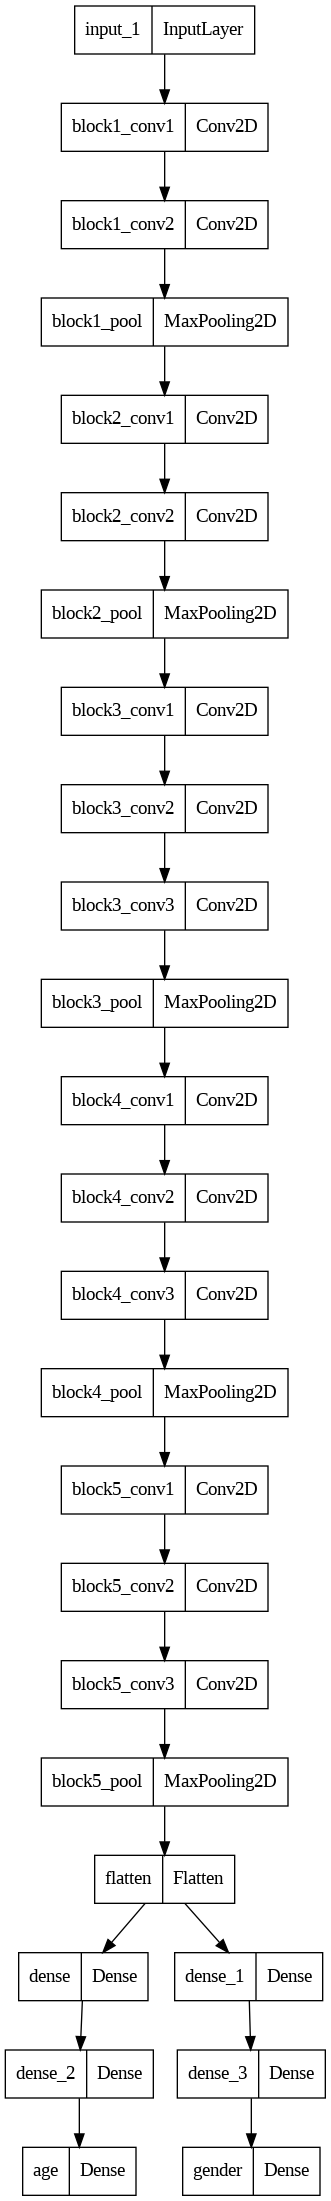

In [24]:
from keras.utils import plot_model
plot_model(model)

In [25]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'},loss_weights={'age':1,'gender':99})

In [27]:
model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 227s 362ms/step - loss: 60.2708 - age_loss: 10.4873 - gender_loss: 0.5029 - age_mae: 10.4873 - gender_accuracy: 0.7534 - val_loss: 43.4330 - val_age_loss: 8.5937 - val_gender_loss: 0.3519 - val_age_mae: 8.5937 - val_gender_accuracy: 0.8387
Epoch 2/10
625/625 [==============================] - 218s 349ms/step - loss: 52.7880 - age_loss: 9.4090 - gender_loss: 0.4382 - age_mae: 9.4090 - gender_accuracy: 0.7933 - val_loss: 42.0460 - val_age_loss: 8.2133 - val_gender_loss: 0.3417 - val_age_mae: 8.2133 - val_gender_accuracy: 0.8457
Epoch 3/10
625/625 [==============================] - 219s 350ms/step - loss: 50.7912 - age_loss: 8.9488 - gender_loss: 0.4227 - age_mae: 8.9488 - gender_accuracy: 0.7995 - val_loss: 43.0891 - val_age_loss: 8.1693 - val_gender_loss: 0.3527 - val_age_mae: 8.1693 - val_gender_accuracy: 0.8344
Epoch 4/10
625/625 [==============================] - 229s 367ms/step - loss: 49.1333 - age_loss: 8.7915 - gender_loss: 0.